In [8]:
%load_ext autoreload
%autoreload 2

import os
import csv
import copy

import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(context='paper', style='darkgrid', font_scale=1.8)


import scipy.stats as stats

from dotmap import DotMap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
env = 'cartpole'
BASE_DIR = './v_logs/{}'.format(env)

CALIB_MODEL_DIR = os.path.join(BASE_DIR, 'PE-DS-calibrate', '2019-01-23--04:53:33')
NO_CALIB_MODEL_DIR = os.path.join(BASE_DIR, 'PE-DS-no-calibrate', '2019-01-23--04:53:42')


def load_log_data(base_dir):
    logs = loadmat(os.path.join(base_dir, 'logs.mat'))
    obs, acs, rewards, returns = logs['observations'], logs['actions'], logs['rewards'], logs['returns']

#     print('Shapes = (n x task_horizon x state_dim)')
#     print('Obs: \t\t', obs.shape)
#     print('Acts: \t\t', acs.shape)
#     print('Rewards: \t', rewards.shape)
#     print()

    
    return obs, acs, rewards, returns

def load_pred_data(base_dir, subdir):
    logs = loadmat(os.path.join(base_dir, subdir, 'predictions.mat'))
    costs, preds = logs['costs'], logs['predictions']
#     print('Shapes = (task_horizon x plan_horizon x particles x action_dims)')
#     print('Costs: \t\t', costs.shape)
#     print('Preds: \t\t', preds.shape)
#     print()
    
    return costs, preds

def load_cal_data(base_dir, subdir):
    logs = loadmat(os.path.join(base_dir, subdir, 'calib_logs.mat'))
    
    all_mus = logs['all_mus']
    all_vars = logs['all_vars']    
    all_ys = logs['all_ys']
    all_cdfs_pred = logs['all_cdfs_pred']
    all_cdfs_pred_cal = logs['all_cdfs_pred_cal']    

    
#     print('Shapes = (n x action_dims)')
#     print('all_mus: \t\t', all_mus.shape)
#     print('all_cdfs_pred: \t\t', all_cdfs_pred.shape)
#     print()
    
    return all_mus, all_vars, all_ys, all_cdfs_pred, all_cdfs_pred_cal

def load_results(model_dir):
    data = loadmat(os.path.join(model_dir, "logs.mat"))
    returns = data['returns'][0]

    return returns

def load_data(train_iter=None):
    subdir = 'train_iter{}'.format(train_iter)
    data = {
        'cal': {
            'model_dir': CALIB_MODEL_DIR
        },
        
        'no-cal': {
            'model_dir': NO_CALIB_MODEL_DIR            
        }
    }
    
    for model_type, info in data.items():
        model_dir = info['model_dir']
        obs, acs, rewards, returns = load_log_data(model_dir)
        costs, preds = calib_log_data = load_pred_data(model_dir, subdir)
        data[model_type]['data'] = obs, acs, rewards, returns, costs, preds
        
        
                   
                
    return data
                     




(15,)
Curr reward:  177.94281363483663
Uncalibrated loss:  1.3645603448275858
Calibrated loss:  0.13634224137931036
(17,)
Curr reward:  177.21277363638106
Uncalibrated loss:  2.368116379310345


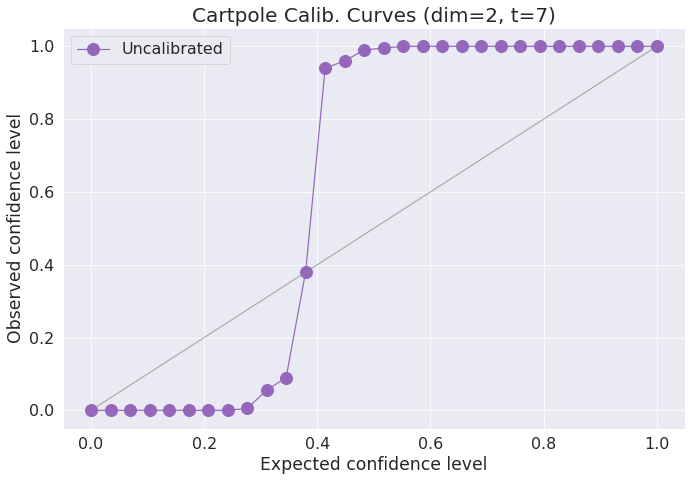

In [87]:

COLORS = ['#9467bd','#2ca02c',   '#e377c2', '#17becf', '#d62728', '#1f77b4']


LINEWIDTH=2
MARKERSIZE=12


def calculate_cal_score(ps, cdf):
    cdf_emp = [np.sum(cdf < p)/len(cdf) for p in ps]
    
    weights = [np.sum(cdf < p) for p in ps]
    weights /= np.sum(weights)
    
    return np.sum(np.square((cdf_emp - ps)))
#     return np.sum(weights* np.square((cdf_emp - ps)))
    

def evaluate_alg(name, model_dir, train_iter=2, d=0, color=None):
    all_mus, all_vars, all_ys, all_cdfs_pred, all_cdfs_pred_cal = load_cal_data(model_dir, 'train_iter{}'.format(train_iter))    
    
    returns = load_results(model_dir)

    mu = all_mus[:, d]
    var = all_vars[:, d]
    ys = all_ys[:, d]

    cdf_pred = all_cdfs_pred[:, d]
    if len(all_cdfs_pred_cal) > 0:
        cdf_pred_cal = all_cdfs_pred_cal[:, d]

    cal_ps = np.linspace(0, 1, num=30)
    
    print(returns.shape)
    print('Curr reward: ', returns[train_iter - 1])
    
    print('Uncalibrated loss: ', calculate_cal_score(cal_ps, cdf_pred))
        


    cdf_emp = [np.sum(cdf_pred < p)/len(cdf_pred) for p in cal_ps]

    if len(all_cdfs_pred_cal) > 0:    
        cdf_emp_cal = [np.sum(cdf_pred_cal < p)/len(cdf_pred_cal) for p in cal_ps]
        print('Calibrated loss: ', calculate_cal_score(cal_ps, cdf_pred_cal))
        
    plt.close('all')
    plt.figure(figsize=(10, 7))
    ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=2)
#     ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.set_title('Cartpole Calib. Curves (dim={}, t={})'.format(d, train_iter), fontsize=20)
    ax1.set_xlabel('Expected confidence level')
    ax1.set_ylabel('Observed confidence level')
    ax1.plot(cal_ps, cdf_emp, "s-", label='Uncalibrated', marker='o', markersize=MARKERSIZE, color='#9467bd')
    if len(all_cdfs_pred_cal) > 0:    
        ax1.plot(cal_ps, cdf_emp_cal, "s-", label='Calibrated', marker='o', markersize=MARKERSIZE, color='#2ca02c')
    ax1.plot(cal_ps, cal_ps, alpha=0.6, color='gray')
    ax1.legend()


    plt.tight_layout()
    plt.savefig(os.path.join('plots', 'cal_{}_dim_{}.png'.format(name, d)), bbox_inches='tight')    
    
    
DIM = 2
TRAIN_ITER = 7
evaluate_alg('calib', CALIB_MODEL_DIR, train_iter=TRAIN_ITER, d=DIM, color='#9467bd')
evaluate_alg('no_calib', NO_CALIB_MODEL_DIR, train_iter=TRAIN_ITER, d=DIM, color='#9467bd')

In [ ]:


I_START = 1
I_END = 8

def get_cal_score_data():
    all_data = []
    for i, exp in enumerate(sorted(os.listdir(BASE_DIR))):
        for subdir in os.listdir(os.path.join(BASE_DIR, exp)):
            print(subdir)
            model_dir = os.path.join(BASE_DIR, exp, subdir)
            data = loadmat(os.path.join(model_dir, "logs.mat"))
            if data["returns"].shape[1] > I_END:
#                 print(exp, subdir, data['returns'][0][min_num_trials-1])
                returns = data["returns"][0][I_START:I_END + 1]
            else:
                continue
   
            avg_cal_scores = []
            for t in range(I_START, I_END + 1):
                all_mus, all_vars, all_ys, all_cdfs_pred, all_cdfs_pred_cal = load_cal_data(model_dir, 'train_iter{}'.format(t))    
                
                cal_scores = []
                for d in range(0, all_mus.shape[-1]):
                    mu = all_mus[:, d]
                    var = all_vars[:, d]
                    ys = all_ys[:, d]

                    cdf_pred = all_cdfs_pred[:, d]
                    if len(all_cdfs_pred_cal) > 0:
                        cdf_pred = all_cdfs_pred_cal[:, d]

                    cal_ps = np.linspace(0, 1, num=30)
                    cal_scores.append(calculate_cal_score(cal_ps, cdf_pred))
                    
                cal_score = np.mean(cal_scores)
                avg_cal_scores.append(cal_score)
            
            all_data.append((avg_cal_scores, returns))
    
        
    return all_data
                            
all_data = get_cal_score_data()        


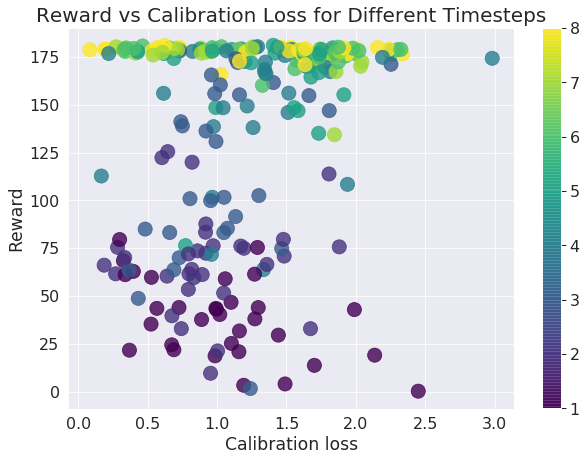

In [150]:

cal_scores = []
rewards = []
times = []
for a,b in all_data:
    cal_scores += a
    times = times + list(range(I_START, I_END + 1))
    rewards = rewards +  list(b)
    

plt.figure(figsize=(10, 7))
plt.scatter(cal_scores, rewards, s=200, c=times, cmap='viridis', alpha=0.8)
# plt.scatter(times, rewards, s=200, c=cal_scores, cmap='viridis', alpha=0.8)
plt.colorbar()
plt.title('Reward vs Calibration Loss for Different Timesteps', fontsize=20)
plt.xlabel('Calibration loss')
plt.ylabel('Reward')
# plt.show()
plt.savefig(os.path.join('plots', 'cartpole_cal_loss_reward_2.png'), bbox_inches='tight')    

            
                
